## 빅데이터 실습

### 다나와 무선청소기 상품 분석

#### 데이터 수집

##### 셀레니움 사용

In [1]:
## 필수 라이브러리 사용등록
from selenium import webdriver
from bs4 import BeautifulSoup
from urllib import parse # url encode
from tqdm import tqdm
import pandas as pd
import time

In [2]:
## 웹드라이버로 크롬 오픈
driver = webdriver.Chrome()
url = r'https://search.danawa.com/dsearch.php?k1=%EC%97%90%EC%96%B4%EB%A9%94%EC%9D%B4%EB%93%9C+%EC%8A%A4%EB%A7%88%ED%8A%B8%ED%83%80%EC%9B%8C&module=goods&act=dispMain'
driver.get(url)


In [3]:
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

In [4]:
prodItems = soup.select('ul.product_list > li.prod_item')
len(prodItems)

3

In [5]:
prodItems[0].select('p.prod_name > a')[0].text.strip()

'에어메이드 스마트타워 AMC-3501A'

In [6]:
prodItems[0].select('div.spec_list')[0].text.strip().replace('\t', '')

'핸디스틱청소기 / 무선 / 흡입형 / 흡입력: 370W / 2024년형 / [구성] 먼지비움 / 충전 / UVC LED / 브러쉬: 바닥 / 침구 / 솔형 / 틈새 / 먼지봉투: 2.5L / [배터리] 사용시간: 40분(최대) / 충전시간: 5시간 / 분리형(1개) / 2500mAh / [청소] LED라이트 / BLDC모터 / [부가] 디스플레이표시 / 헤파필터 / 색상: 화이트 / 무게: 2.5kg / 크기(가로x세로x깊이): 252x1253x185mm'

In [7]:
# 만약 수가 아닌 문자열일땐 False
# isdecimal() 메서드는 문자열이 모두 10진수로 표현될 수 있는지 여부를 확인
prodItems[0].select('input')[1].get('value').isdecimal()

True

#### 다나와 무선청소기 웹크롤링 (~day07)
- 가격외에는 안들어오도록 변환

In [8]:
## 검색어, 페이지를 변경하면서 URL 생성함수
def getSearchPageUrl(keyword, page):
    ecKeyword = parse.quote(keyword)
    url = f'https://search.danawa.com/dsearch.php?query={ecKeyword}&originalQuery={ecKeyword}&previousKeyword={ecKeyword}&checkedInfo=N&volumeType=allvs&' + \
          f'page={page}&limit=120&sort=saveDESC&list=list&boost=true&tab=goods&addDelivery=N&coupangMemberSort=N&mode=simple&isInitTireSmartFinder=N&' + \
           'recommendedSort=N&defaultUICategoryCode=10325109&defaultPhysicsCategoryCode=72%7C80%7C81%7C0&defaultVmTab=3138&defaultVaTab=1098867&isZeroPrice=Y&' + \
           'quickProductYN=N&priceUnitSort=N&priceUnitSortOrder=A'
    return url

In [9]:
## 상품정보 추출하는 함수
def getProdItems(prodItems):
    prodData = []

    for prodItem in prodItems:
        try:
            prodName = prodItem.select('p.prod_name > a')[0].text.strip()  # 상품명 가져오기
            specList = prodItem.select('div.spec_list')[0].text.strip().replace('\t', '') # 상품 스펙목록 가져오기

            if prodItem.select('input')[1].get('value').isdecimal() == True: 
                price = prodItem.select('input')[1].get('value') # 최저가 가져오기
            else:
                price = 0 # 문자열 들어온 것 막음

            prodData.append([prodName, specList, price])
        except:
            pass
    
    return prodData

In [10]:
## 여러페이지 검색후 크롤링하는 작업
driver = webdriver.Chrome()
# 암묵적으로 웹 자원 로드를 위해 3초정도 대기
driver.implicitly_wait(3.0)

keyword = '무선청소기'
startPage = 1
totalPage = 20
prodDataTotal = [] # 최종적으로 저장할 리스트

for page in tqdm(range(startPage, totalPage +1)):
    # 검색 페이지 이동
    url = getSearchPageUrl(keyword, page)
    driver.get(url)
    # 페이지 로딩이 완료될때까지 5초간 대기
    time.sleep(5)

    # 현재 페이지 HTML 가져오기
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')

    # 상품정보 추출
    prodItems = soup.select('ul.product_list > li.prod_item')
    prodItemList = getProdItems(prodItems) # 리스트로 추출하는 함수

    # 추출된 정보를 prodDataTotal 추가
    prodDataTotal += prodItemList   

100%|██████████| 20/20 [02:49<00:00,  8.49s/it]


In [11]:
len(prodDataTotal)

2130

In [57]:
dfProdDataTotal = pd.DataFrame(prodDataTotal)

In [13]:
dfProdDataTotal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2130 entries, 0 to 2129
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2130 non-null   object
 1   1       2130 non-null   object
 2   2       2130 non-null   object
dtypes: object(3)
memory usage: 50.1+ KB


In [59]:
dfProdDataTotal.columns = ['제품명','제품스펙','최저가']

In [60]:
len(dfProdDataTotal)

2130

In [61]:
dfProdDataTotal.to_excel('./data/다나와_무선청소기_결과.xlsx', index=False)

#### 크롤링 데이터 전처리

In [63]:
# 저장한 엑셀을 재로드
dfProdDataLoad = pd.read_excel('./data/다나와_무선청소기_결과.xlsx')
dfProdDataLoad.tail()

,제품명,제품스펙,최저가
2125,한샘 마이홈 스톰 MSA-AS22,물걸레청소기 / 회전식 / 물걸레전용 / 무선 / 소비전력: 50W / [배터리] ...,220000
2126,LG전자 코드제로 싸이킹 K95,진공청소기 / 무선 / 소비전력: 600W / [성능] 싸이클론흡입 / 먼지압축 /...,1359230
2127,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
2128,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
2129,업킵 MJ-BC779,침구청소기 / 핸디형 / 무선 / [기능] 청소모드: UV살균 / 속도조절 / 헤파...,89900


In [64]:
dfProdDataLoad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2130 entries, 0 to 2129
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제품명     2130 non-null   object
 1   제품스펙    2120 non-null   object
 2   최저가     2130 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 50.1+ KB


In [65]:
dfProdDataLoad.isnull().sum()

제품명      0
제품스펙    10
최저가      0
dtype: int64

In [66]:
# '제품스펙' 열의 값이 NaN (누락된 데이터)인지 여부를 검사하는 조건 생성
condition = dfProdDataLoad['제품스펙'].isnull() == True # 각 열의 값이 NaN (누락된 데이터)인지 여부를 검사
# 조건을 사용하여 결측치가 포함된 행을 선택하여 반환
dfProdDataLoad[condition]

,제품명,제품스펙,최저가
1863,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
1864,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
1929,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
1930,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
1995,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
1996,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
2061,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
2062,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
2127,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
2128,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0


In [67]:
## 결측치가 있는 행(row)을 삭제
dfProdDataLoad = dfProdDataLoad.dropna(axis=0)

In [68]:
# 최저가가 0인 제품
condition = dfProdDataLoad['최저가'] == 0

In [69]:
# 최저가가 0인 제품을 제외한 나머지
dfProdDataLoad = dfProdDataLoad[condition == False]

In [70]:
# 행들이 삭제되면서 인덱스가 꼬임 >> 인덱스 초기화
# drop=True >> 기존 인덱스를 새로운 열로 추가하지 않고 삭제
# inplace=True >> 재설정된 인덱스가 데이터프레임에 바로 적용
dfProdDataLoad.reset_index(drop=True, inplace=True)

In [71]:
# 결측치, 이상치를 제거한 최종 DF
# 회사명, 모델명, 카테고리, 사용시간, 흡입력 추출한 결과도 2068개가 필수
dfProdDataLoad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2068 entries, 0 to 2067
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제품명     2068 non-null   object
 1   제품스펙    2068 non-null   object
 2   최저가     2068 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 48.6+ KB


In [72]:
# 제조회사, 제품명 분리 split(' ', n) n => 자를 공백의 번호
dfProdDataLoad['제품명'][:5][0].split(' ', 1)

['LG전자', '오브제컬렉션 코드제로 A9S AX9884']

In [81]:
## 회사명, 모델명 분리 시작
compList = []
modelList = []
count = 0

for temp in dfProdDataLoad['제품명']:
    titles = temp.split(' ', 1) # 길이 2 배열 생성
    if (len(titles) > 1):
        compList.append(titles[0]) # 회사명
        modelList.append(titles[1]) # 모델명
    else:
        compList.append('') # 회사명은 비운다
        modelList.append(titles[0]) # 모델명

    count +=1  

In [75]:
len(compList)

2068

In [82]:
len(modelList)

2068

In [83]:
# 스펙목록 데이터
specList = dfProdDataLoad.loc[2000, '제품스펙'].split(' / ')

In [84]:
specList

['침구청소기',
 '핸디형',
 '무선',
 '충전시간: 2시간',
 '[기능] 청소모드: UV살균, 흡입',
 '흡입력: 7500Pa',
 '헤파필터',
 '색상: 블랙',
 '무게: 1.1kg']

In [86]:
useTime = ''
suctionPow = ''
for spec in specList:
    if '사용시간' in spec: # '사용시간'을 포함하는 문자열을 찾아 useTime에 할당
        useTime = spec
    elif '흡입력' in spec: # '흡입력'을 포함하는 문자열을 찾아 suctionPow에 할당
        suctionPow = spec

# 할당된 문자열을 공백을 기준으로 분리하고, 두 번째 요소를 추출한 뒤 양쪽 공백을 제거하여 출력
print(useTime.split(' ')[1].strip())
print(suctionPow.split(' ')[1].strip()) # 흡입력이 없어서 ''경우는 split(' ')에서 예외발생

IndexError: list index out of range

In [87]:
dfProdDataLoad.loc[0, '제품스펙']

'핸디스틱청소기 / 무선 / 흡입+물걸레(동시) / 흡입력: 250W / 소비전력: 620W / 2023년형 / [구성] 거치대: 올인원타워 / 먼지비움 / 충전 / UVC LED / 액서서리수납 / 스탠드거치 / 먼지비움시간: 30초 / 브러쉬: 와이드바닥 / 물걸레: 스팀, 고온, 일반 / 솔형 / 틈새 / 먼지봉투: 2.5L / [배터리] 사용시간: 30분(최대) / 충전시간: 4시간 / 분리형(2개) / 리튬이온 / 25.2V / [청소] 싸이클론흡입 / LED라이트 / 자동물공급 / 스마트인버터모터 / [부가] 스마트폰제어 / 대화형알림창 / 워셔블헤파필터 / 5단계여과 / 색상: 카밍베이지 / 무게: 2.47kg / 크기(가로x세로x깊이): 300x1120x245mm'

In [105]:
categoryList = []  # 카테고리를 저장할 리스트
usageTimeList = []  # 사용시간을 저장할 리스트
suctionPowerList = []  # 흡입력을 저장할 리스트
count = 0

# '제품스펙' 열의 각 행을 반복하여 카테고리, 사용시간, 흡입력을 추출
for spec in dfProdDataLoad['제품스펙'] : 
    # ' / '로 문자열을 분리하여 리스트로 만듦
    specList = spec.split(' / ')

    # 카테고리 추출
    category = specList[0] # 문자열 양쪽의 공백 제거 후 카테고리에 추가
    categoryList.append(category)

    # 사용시간과 흡입력을 추출하기 위한 변수 초기화
    usageTimeVal = None
    suctionPowerVal = None
    
    # '사용시간'과 '흡입력'을 포함한 문자열을 찾아 해당 값을 변수에 할당    
    for temp in specList :
        if '사용시간' in temp :
            usageTimeVal = temp.replace('[배터리] ', '')  # [베터리] 값 오류 발생 방지
        elif '흡입력' in temp :
            suctionPowerVal = temp.strip()

    # 추출된 사용시간을 처리
    if usageTimeVal != None:
        # ':'를 기준으로 문자열을 분리하고, 분리된 문자열의 두 번째 요소를 추출하여 공백 제거 후 사용시간에 할당
        usageTime = usageTimeVal.split(' ')[1].strip().replace('(최대)', ' ')  # 사용시간 정보 추출
    else:
        # 사용시간 정보가 없는 경우 빈 문자열을 사용시간에 할당
        usageTime = ' '

    # 추출된 흡입력을 처리
    if suctionPowerVal is not None:
        # ':'를 기준으로 문자열을 분리하고, 분리된 문자열의 두 번째 요소를 추출하여 공백 제거 후 흡입력에 할당
        suctionPower = suctionPowerVal.split(' ')[1].strip()  # 흡입력 정보 추출
    else:
        # 흡입력 정보가 없는 경우 빈 문자열을 흡입력에 할당
        suctionPower = ''

    # 추출한 값들을 각각의 리스트에 추가
    usageTimeList.append(usageTime)
    suctionPowerList.append(suctionPower)

    count += 1
  

In [91]:
len(usageTimeList)

2068

In [92]:
len(suctionPowerList)

2068

In [106]:
usageTimeList

['30분 ',
 '1시간 ',
 ' ',
 '1시간 ',
 '30분 ',
 '1시간 ',
 '30분 ',
 '1시간 ',
 '45분 ',
 '50분 ',
 '1시간30분 ',
 '50분 ',
 '1시간 ',
 '50분 ',
 '30분 ',
 '1시간 ',
 '30분 ',
 '1시간 ',
 '1시간 ',
 '12분 ',
 '1시간 ',
 '30분 ',
 '30분 ',
 '1시간 ',
 '1시간 ',
 '40분 ',
 '1시간 ',
 '1시간 ',
 '1시간20분 ',
 '1시간 ',
 '43분 ',
 '40분 ',
 '1시간 ',
 '1시간 ',
 '1시간 ',
 '53분 ',
 '30분 ',
 '50분 ',
 ' ',
 '20분 ',
 '30분 ',
 '1시간 ',
 '18분 ',
 '30분 ',
 '32분 ',
 '1시간 ',
 '1시간 ',
 '1시간 ',
 '1시간 ',
 '50분 ',
 '1시간 ',
 '1시간 ',
 '42분 ',
 '1시간 ',
 '1시간 ',
 '30분 ',
 '60분 ',
 '30분 ',
 '1시간 ',
 '30분 ',
 '30분 ',
 '1시간 ',
 '1시간 ',
 '1시간40분 ',
 '50분 ',
 '10~15분 ',
 '1시간 ',
 '1시간 ',
 '30분 ',
 '1시간 ',
 '30분 ',
 '30분 ',
 '40분 ',
 '30분 ',
 '20분 ',
 '1시간20분 ',
 '40분 ',
 '30분 ',
 '30분 ',
 '30분 ',
 '1시간 ',
 '40분 ',
 '30분 ',
 '1시간 ',
 '30분 ',
 '1시간 ',
 '40분 ',
 '1시간 ',
 '57분 ',
 '1시간 ',
 '1시간 ',
 '50분 ',
 '1시간 ',
 ' ',
 '1시간 ',
 '1시간 ',
 '45분 ',
 '40분 ',
 '45분 ',
 '35분 ',
 '30분 ',
 '40분 ',
 '1시간 ',
 '50분 ',
 '43분 ',
 '1시간 ',
 '40분 ',
 '50분 ',
 '45분 ',
 '40분 ',
 '1시

In [107]:
suctionPowerList

['250W',
 '220W',
 '',
 '210W',
 '250W',
 '280W',
 '250W',
 '220W',
 '',
 '160W',
 '25000Pa',
 '150W',
 '250W',
 '40000Pa',
 '9000Pa',
 '220W',
 '280W',
 '151AW',
 '220W',
 '',
 '220W',
 '',
 '250W',
 '115AW',
 '220W',
 '15000Pa',
 '220W',
 '250W',
 '280W',
 '240AW',
 '17000Pa',
 '200W',
 '22000Pa',
 '130AW',
 '220W',
 '',
 '',
 '35000Pa',
 '',
 '60W',
 '250W',
 '25000Pa',
 '22000Pa',
 '250W',
 '23000Pa',
 '200W',
 '220W',
 '140AW',
 '220W',
 '',
 '140AW',
 '210W',
 '',
 '220W',
 '27000Pa',
 '250W',
 '',
 '280W',
 '',
 '250W',
 '250W',
 '150AW',
 '220W',
 '280W',
 '35000Pa',
 '',
 '210W',
 '220W',
 '250W',
 '220W',
 '250W',
 '250W',
 '100AW',
 '250W',
 '',
 '280W',
 '12000Pa',
 '250W',
 '250W',
 '250W',
 '240AW',
 '200W',
 '250W',
 '17000Pa',
 '280W',
 '210W',
 '12000Pa',
 '151AW',
 '',
 '200AW',
 '220W',
 '23000Pa',
 '210W',
 '9000Pa',
 '220W',
 '200AW',
 '',
 '35000Pa',
 '23000Pa',
 '12000Pa',
 '',
 '42000Pa',
 '185AW',
 '25000Pa',
 '17000Pa',
 '',
 '150W',
 '20000Pa',
 '',
 '',
 '15

In [108]:
## 사용시간 단위 통일
# time = '1시간', '30분', '1시간 20분' ...etc  >>  분으로 통일
def convertHourToMin(time) :
    try :
        if '시간' in time :
            hour = time.split('시간')[0]
            if '분' in time :
                minute = time.split('시간')[-1].split('분')[0]
            else :
                minute = 0
        else :
            hour = 0
            minute = time.split('분')[0]
        return int(hour)*60 + int(minute)
    except :
        return None

In [109]:
convertHourToMin('1시간30분')

90

In [110]:
newUsageTimeList = []
# 각 사용시간을 변환하여 새로운 리스트에 저장
for time in usageTimeList :
    value = convertHourToMin(time) # convertHourToMin() 함수를 사용하여 시간을 분으로 변환
    newUsageTimeList.append(value) # 변환된 값을 새로운 리스트에 추가

# 변환된 사용시간의 개수 확인
len(newUsageTimeList)

2068

In [111]:
# 변경한 사용시간 확인
newUsageTimeList

# None >> 사용시간 없음

[30,
 60,
 None,
 60,
 30,
 60,
 30,
 60,
 45,
 50,
 90,
 50,
 60,
 50,
 30,
 60,
 30,
 60,
 60,
 12,
 60,
 30,
 30,
 60,
 60,
 40,
 60,
 60,
 80,
 60,
 43,
 40,
 60,
 60,
 60,
 53,
 30,
 50,
 None,
 20,
 30,
 60,
 18,
 30,
 32,
 60,
 60,
 60,
 60,
 50,
 60,
 60,
 42,
 60,
 60,
 30,
 60,
 30,
 60,
 30,
 30,
 60,
 60,
 100,
 50,
 None,
 60,
 60,
 30,
 60,
 30,
 30,
 40,
 30,
 20,
 80,
 40,
 30,
 30,
 30,
 60,
 40,
 30,
 60,
 30,
 60,
 40,
 60,
 57,
 60,
 60,
 50,
 60,
 None,
 60,
 60,
 45,
 40,
 45,
 35,
 30,
 40,
 60,
 50,
 43,
 60,
 40,
 50,
 45,
 40,
 60,
 20,
 70,
 20,
 20,
 62,
 42,
 30,
 None,
 50,
 40,
 28,
 35,
 44,
 None,
 50,
 None,
 50,
 80,
 60,
 35,
 60,
 65,
 50,
 60,
 50,
 25,
 30,
 30,
 60,
 48,
 40,
 75,
 60,
 None,
 50,
 60,
 40,
 55,
 40,
 60,
 9,
 20,
 45,
 50,
 78,
 9,
 10,
 30,
 30,
 60,
 48,
 33,
 45,
 45,
 60,
 100,
 65,
 60,
 80,
 80,
 53,
 50,
 60,
 35,
 45,
 None,
 None,
 60,
 80,
 32,
 40,
 60,
 53,
 60,
 30,
 None,
 60,
 12,
 10,
 None,
 30,
 None,
 50,
 45,

In [112]:
# 정규 표현식(Regular Expression) 모듈을 불러오는 코드
import re

def convertUnit(value):
    try:
        if 'W' in value:  # 흡입력에 'W'가 포함된 경우
            # 숫자만 추출하여 반환
            value = re.findall(r'\d+', value)[0]
            return f"{value}"
        elif 'Pa' in value:  # 흡입력에 'Pa'가 포함된 경우
            # Pa를 W로 변환하여 반환
            value = int(re.findall(r'\d+', value)[0]) // 100  # Pa를 W로 변환
            return f"{value}"
        elif 'AW' in value:  # 흡입력에 'AW'가 포함된 경우
            # AW를 W로 변환하여 반환
            value = int(re.findall(r'\d+', value)[0])  # AW를 W로 변환
            return f"{value}"
        else:
            return None
    except:
        return None

# 테스트를 위한 흡입력 값 리스트
suction_power_list = ['250W', '220W', '', '250W', '280W', '220W', '250W', '210W', '160W', '150W', '25000Pa', '250W', '9000Pa', '40000Pa', '220W', '', '280W', '151AW', '240AW', '280W', '220W', '220W', '', '115AW', '220W']

# 모든 흡입력 값을 'W'로 통일시킨 결과 출력
unified_suction_power_list = [convertUnit(unit) for unit in suction_power_list]
print(unified_suction_power_list)

['250', '220', None, '250', '280', '220', '250', '210', '160', '150', '250', '250', '90', '400', '220', None, '280', '151', '240', '280', '220', '220', None, '115', '220']


In [113]:
newSuctionList = []
for power in suctionPowerList :
    value = convertUnit(power)
    newSuctionList.append(value)

In [114]:
len(newSuctionList)

2068

In [115]:
# 최종 데이터 엑셀 저장
dfLast = pd.DataFrame()
dfLast['카테고리'] = categoryList
dfLast['제조회사'] = compList
dfLast['제품명'] = modelList
dfLast['가격'] = dfProdDataLoad['최저가']
dfLast['사용시간'] = newUsageTimeList
dfLast['흡입력'] = newSuctionList

In [116]:
dfLast.tail()

,카테고리,제조회사,제품명,가격,사용시간,흡입력
2063,물걸레청소기,,에이블텐,198000,30.0,None
2064,침구청소기,SHILONG,CMY-01,33800,NaN,75
2065,물걸레청소기,한샘,마이홈 스톰 MSA-AS22,220000,22.0,None
2066,진공청소기,LG전자,코드제로 싸이킹 K95,1359230,40.0,None
2067,침구청소기,업킵,MJ-BC779,89900,NaN,None


In [117]:
dfLast.to_excel('./data/다나와_무선청소기_전처리결과.xlsx', index=False)

#### 무선 청소기 분석전 결측치 한번 더 제거

In [118]:
dfCleaner =  pd.read_excel('./data/다나와_무선청소기_전처리결과.xlsx')

In [119]:
# 각 영역마다 null값 확인
dfCleaner.isnull().sum()

카테고리       0
제조회사      24
제품명        0
가격         0
사용시간     379
흡입력     1007
dtype: int64

In [369]:
dfCleaner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   카테고리    2400 non-null   object 
 1   제조회사    2400 non-null   object 
 2   제품명     2400 non-null   object 
 3   가격      2400 non-null   int64  
 4   사용시간    2300 non-null   float64
 5   흡입력     1980 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 112.6+ KB


In [121]:
# 제조회사 빠진조건
condition = dfCleaner['제조회사'].isnull() == True

In [122]:
## 회사명 빠진것 10건은 직접 수동으로 채워넣음
dfCleaner[condition]

,카테고리,제조회사,제품명,가격,사용시간,흡입력
238,핸디스틱청소기,NaN,LT-124,29980,240.0,80.0
663,창문청소기,NaN,YLW6305D,26310,30.0,110.0
788,탁상용청소기,NaN,KKGTL,19800,NaN,NaN
909,핸디스틱청소기,NaN,브라프,98000,20.0,130.0
910,핸디스틱청소기,NaN,홈룸,69800,25.0,NaN
911,핸디스틱청소기,NaN,스웨덴,118000,NaN,100.0
923,핸디스틱청소기,NaN,ZC1018,89900,25.0,NaN
924,핸디스틱청소기,NaN,SC-100,69800,30.0,NaN
1236,핸디스틱청소기,NaN,ZEK-K8,157640,NaN,150.0
1292,탁상용청소기,NaN,티후,5400,NaN,NaN


In [123]:
# 사용시간 NaN 확인
condition = dfCleaner['사용시간'].isnull() == True

dfCleaner[condition]

,카테고리,제조회사,제품명,가격,사용시간,흡입력
2,핸디스틱청소기,샤오미,미홀 M22,151050,NaN,NaN
38,핸디스틱청소기,삼성전자,파워스틱 VS02R6512JG,217490,NaN,NaN
65,핸디스틱청소기,보만,VC7210,47900,NaN,NaN
93,핸디스틱청소기,JONR,ED11,125560,NaN,90.0
118,핸디스틱청소기,기펠,ZET-10,234740,NaN,NaN
...,...,...,...,...,...,...
2050,침구청소기,SHILONG,UV 세트형,20800,NaN,100.0
2057,업소용청소기,UDT,UD-920,470000,NaN,NaN
2059,업소용청소기,아이맙,i-mop XXL,10727200,NaN,NaN
2064,침구청소기,SHILONG,CMY-01,33800,NaN,75.0


In [124]:
## 사용시간, 흡입력 NaN 전부 0으로 채워넣기
dfCleaner = dfCleaner.fillna(0)

In [125]:
# NaN값 없는것 확인
dfCleaner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2068 entries, 0 to 2067
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   카테고리    2068 non-null   object 
 1   제조회사    2068 non-null   object 
 2   제품명     2068 non-null   object 
 3   가격      2068 non-null   int64  
 4   사용시간    2068 non-null   float64
 5   흡입력     2068 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 97.1+ KB


### 제품별 분석

#### 필요제품만 선별

In [126]:
# 카테고리별 제품 개수 >> wordCloud 가능
dfCleaner['카테고리'].value_counts()

카테고리
핸디스틱청소기                1125
물걸레청소기                  269
차량용청소기                  250
침구청소기                   109
욕실청소기                    81
업소용청소기                   60
탁상용청소기                   52
핸디스틱청소기+로봇청소기            34
스틱청소기                    27
진공청소기                    13
창문청소기                    11
스팀청소기                     9
수영장청소기                    5
핸디/스틱청소기+핸디/스틱청소기         4
카펫소파청소기                   4
로봇청소기                     4
핸디스틱청소기+공기청정기세트           4
욕실+물걸레청소기                 1
핸디스틱청소기+핸디스틱청소기세트         1
핸디스틱청소기+가습기세트             1
핸디스틱청소기+공기청정기+가습기세트       1
신발세척기                     1
차량용선풍기                    1
핸디스틱청소기+물걸레청소기세트          1
Name: count, dtype: int64

In [127]:
# TEST -> 워드클라우드 가능
dfTest = pd.DataFrame( dfCleaner['제조회사'].value_counts())
dfTest.reset_index().head(5)

,제조회사,count
0,삼성전자,143
1,LG전자,127
2,신일전자,77
3,다이슨,75
4,샤오미,67


In [129]:
## 핸디스틱청소기만 분석
dfDataFinal = dfCleaner[dfCleaner['카테고리'].isin(['핸디스틱청소기', '핸디스틱청소기+로봇청소기', '스틱청소기', '진공청소기'])]

dfDataFinal

,카테고리,제조회사,제품명,가격,사용시간,흡입력
0,핸디스틱청소기,LG전자,오브제컬렉션 코드제로 A9S AX9884,882430,30.0,250.0
1,핸디스틱청소기,삼성전자,비스포크 제트 VS20B956AX,446390,60.0,220.0
2,핸디스틱청소기,샤오미,미홀 M22,151050,0.0,0.0
3,핸디스틱청소기,LG전자,오브제컬렉션 코드제로 A9 AS9202WD,457000,60.0,210.0
4,핸디스틱청소기,LG전자,오브제컬렉션 코드제로 A9S AX9604,714720,30.0,250.0
...,...,...,...,...,...,...
1938,진공청소기,LG전자,코드제로 싸이킹 K95,1359230,40.0,0.0
1963,진공청소기,마끼다,DCL501,761200,0.0,66.0
2002,진공청소기,LG전자,코드제로 싸이킹 K95,1359230,40.0,0.0
2027,진공청소기,마끼다,DCL501,761200,0.0,66.0


In [436]:
# 중복을 제거한 원본 데이터프레임을 생성 (경고를 무시)
dfDataFinal.drop_duplicates(subset='제품명', keep='first', inplace=True)

In [437]:
dfDataFinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   카테고리    118 non-null    object
 1   제조회사    118 non-null    object
 2   제품명     118 non-null    object
 3   가격      118 non-null    int64 
 4   사용시간    118 non-null    int64 
 5   흡입력     118 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 5.7+ KB


In [130]:
dfDataFinal.to_excel('./data/2_danawa_data_final.xlsx', index=False)

#### 분석용 재로드

In [131]:
dfDataFinal = pd.read_excel('./data/2_danawa_data_final.xlsx')

In [132]:
dfDataFinal.tail()

,카테고리,제조회사,제품명,가격,사용시간,흡입력
1194,진공청소기,LG전자,코드제로 싸이킹 K95,1359230,40,0
1195,진공청소기,마끼다,DCL501,761200,0,66
1196,진공청소기,LG전자,코드제로 싸이킹 K95,1359230,40,0
1197,진공청소기,마끼다,DCL501,761200,0,66
1198,진공청소기,LG전자,코드제로 싸이킹 K95,1359230,40,0


In [133]:
# 흡입력 기준으로 정렬, ascending=Treu(오름차순), ascending=False(내림차순)
suctionTopList = dfDataFinal.sort_values(['흡입력'], ascending=False)
suctionTopList.head()

,카테고리,제조회사,제품명,가격,사용시간,흡입력
99,핸디스틱청소기,아이룸,윈드포스 F9,178000,40,420
381,핸디스틱청소기,비브르,V38 스페셜 에디션,195000,50,410
13,핸디스틱청소기,DIBEA,ALLNEW29000 PLUS,241530,50,400
131,핸디스틱청소기,DIBEA,ALLNEW22000+,199000,50,390
390,핸디스틱청소기,행커,400W,197990,60,390


In [134]:
# 사용시간 기준 정렬
useTimeTopList = dfDataFinal.sort_values(['사용시간'], ascending=False)
useTimeTopList.head()

,카테고리,제조회사,제품명,가격,사용시간,흡입력
823,핸디스틱청소기,기펠,BTS-5000,471980,240,0
1018,핸디스틱청소기,라이녹스,원큐 RXBC-C200,174830,240,0
229,핸디스틱청소기,0,LT-124,29980,240,80
341,핸디스틱청소기,헤몬,ST-6655,39000,180,120
652,핸디스틱청소기,무궁화전자,바로바로 MDC-900,222270,150,0


In [135]:
# 사용시간, 흡입력 동시 기준 정렬
topList = dfDataFinal.sort_values(['사용시간', '흡입력'], ascending=False)
topList.head()

,카테고리,제조회사,제품명,가격,사용시간,흡입력
229,핸디스틱청소기,0,LT-124,29980,240,80
823,핸디스틱청소기,기펠,BTS-5000,471980,240,0
1018,핸디스틱청소기,라이녹스,원큐 RXBC-C200,174830,240,0
341,핸디스틱청소기,헤몬,ST-6655,39000,180,120
636,핸디스틱청소기,무궁화전자,바로바로 MDC-910,225450,150,0


In [136]:
## 가성비 제품 찾기 전
# 평균값 구하기
priceMean = round(dfDataFinal['가격'].mean(), 2)
suctionMean = round(dfDataFinal['흡입력'].mean(),2)
usageTimeMean = round(dfDataFinal['사용시간'].mean(), 2)
print(f'----평균가격 : {priceMean}원, ---- 평균흡입력: {suctionMean}W, ---- 평균사용시간: {usageTimeMean}분 ----')

----평균가격 : 466968.46원, ---- 평균흡입력: 115.41W, ---- 평균사용시간: 39.62분 ----


In [137]:
## 가성비 좋은 제품
condition1 = dfDataFinal['가격'] <= priceMean
condition2 = dfDataFinal['흡입력'] >= suctionMean
condition3 = dfDataFinal['사용시간'] >= usageTimeMean

In [138]:
## 가성비 좋은 제품 분석
chartData = dfDataFinal[condition1 & condition2 & condition3]

#### 데이터 시각화

In [140]:
# 필요라이브러리 사용등록
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [141]:
sns.set_style('darkgrid')

In [142]:
# 한글 꺠짐문제 해결
from matplotlib import rc

rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

In [143]:
## 흡입력, 사용시간 최대값, 최소값
suctionMax = chartData['흡입력'].max() # 420
useTimeMax = chartData['사용시간'].max() # 180
suctionMean = chartData['흡입력'].mean() # 229 
useTimeMean = chartData['사용시간'].mean() # 51.9

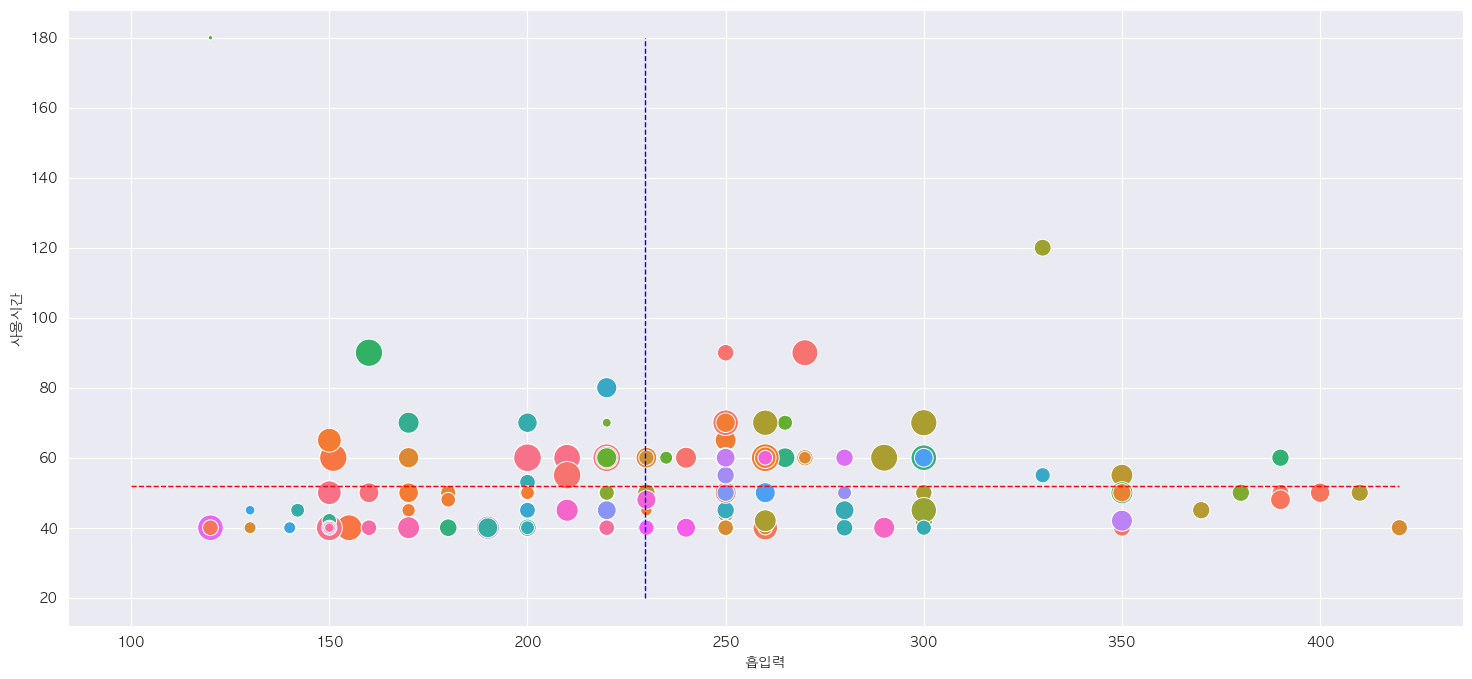

In [144]:
fig = plt.figure(figsize=(18, 8))

sns.scatterplot(data=chartData, x='흡입력', y='사용시간', size='가격', sizes=(10, 400), hue=chartData['제조회사'], legend=False)
plt.plot([100, suctionMax], [useTimeMean, useTimeMean], 'r--', lw=1) # 사용시간 평균치 줄표시
plt.plot([suctionMean, suctionMean], [20, useTimeMax], 'b--', lw=1) # 흡입력 평균치 줄표시

plt.show()

In [145]:
# chartData에서 상위 20개의 행을 선택하여 새로운 데이터프레임을 생성
chartDataTop = chartData[:20]

In [146]:
chartDataTop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 1 to 90
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   카테고리    20 non-null     object
 1   제조회사    20 non-null     object
 2   제품명     20 non-null     object
 3   가격      20 non-null     int64 
 4   사용시간    20 non-null     int64 
 5   흡입력     20 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 1.1+ KB


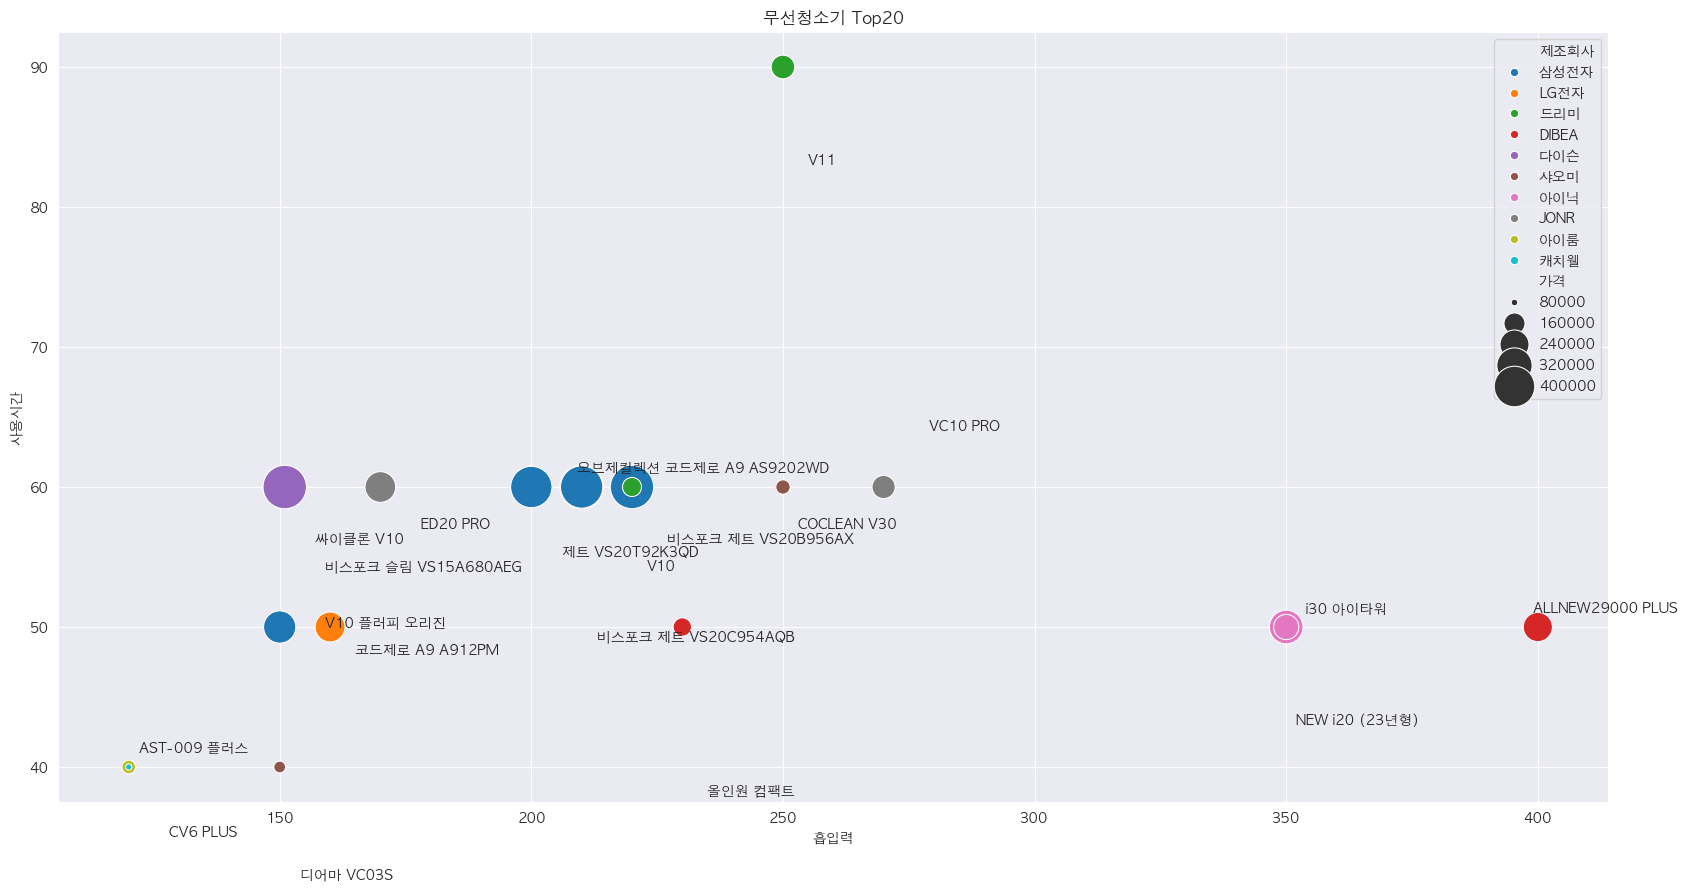

In [155]:
import random

# 인기제품 시각화
fig = plt.figure(figsize=(20, 10))
plt.title('무선청소기 Top20')
sns.scatterplot(data=chartDataTop, x='흡입력', y='사용시간', size='가격', sizes=(20, 1000),
                hue=chartDataTop['제조회사'])

for index, row in chartDataTop.iterrows():
    x = row['흡입력'] + random.randrange(-3, 10)
    y = row['사용시간'] + random.randrange(-13, 5)
    s = row['제품명']
    plt.text(x, y, s, size=10)

plt.show()

##### 결론
1. 데이터분석을 위한 전처리는 쉽지 않음
2. 결과들이 예상이나, 실제와 많이 다름